In [ ]:
%pip install ord_schema
%pip install wget

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ord_schema
from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2

import pandas as pd
import numpy as np

import os
import wget
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

### Part 1. Data parsing

In [ ]:
def get_value_by_type(data, type_value, type_key = 'type', value_key = 'value'):
  '''Returns value for a given type from XML-like structure'''
  for child in data:
    if getattr(child, type_key, None) == type_value:
      return getattr(child, value_key, None)
  return None

In [ ]:
def get_product_yield(prod):
  '''Returns product yield'''
  if len(prod.measurements)==0:
    y = None
  else:
    for i in range(len(prod.measurements)):
      y = prod.measurements[i].percentage.value
      if y == 0:
        y = None
      break
  return y

In [ ]:
def parse_reactions_from_dataset(data):

  '''Parses reactions information from a given dataset'''

  # reactions list
  reactions_list = []

  # iterate over reactions in dataset
  for i, r in enumerate(data.reactions):

    reaction_dict = dict()
    inputs_reaction_roles, inputs_smiles, outcomes_reaction_roles, outcomes_smiles, yields = [], [], [], [], []

    # get reaction id
    reaction_dict['reaction_id'] = r.reaction_id

    # get reaction smiles
    reaction_smiles = get_value_by_type(r.identifiers, 6) # 6 = REACTION_CXSMILES (extended smiles)
    reaction_dict['reaction_smiles'] = reaction_smiles if reaction_smiles != None else get_value_by_type(r.identifiers, 2) # 2 = REACTION_SMILES (regular smiles)

    # get reaction type
    reaction_dict['reaction_type'] = get_value_by_type(r.identifiers, 5) # 5 = reaction type

    # iterate over inputs and components
    for inp in r.inputs.values():
      for comp in inp.components:
        # get component reaction role
        reaction_role = getattr(comp, 'reaction_role', None)
        inputs_reaction_roles.append(reaction_role)
        # get component identifier
        identifier = get_value_by_type(comp.identifiers, 2) # 2 = smiles
        if identifier == None:
          identifier = get_value_by_type(comp.identifiers, 6) # 6 = name
        inputs_smiles.append(identifier)
    reaction_dict['inputs_reaction_roles'] = inputs_reaction_roles
    reaction_dict['inputs_smiles'] = inputs_smiles
  
    # iterate over outcomes
    for out in r.outcomes:
      # get reaction time
      reaction_time = getattr(out, 'reaction_time', None)
      if reaction_time.units != 0: # we need this condition because if there is no reaction time it returns 0 (not None)
        reaction_dict['reaction_time_value'] = reaction_time.value
        reaction_dict['reaction_time_units'] = reaction_time.units

      # iterate over products
      for prod in out.products:
        # get product reaction role
        reaction_role = getattr(prod, 'reaction_role', None)
        outcomes_reaction_roles.append(reaction_role)
        # get product identifier
        identifier = get_value_by_type(prod.identifiers, 2) # 2 = smiles
        if identifier == None:
          identifier = get_value_by_type(prod.identifiers, 6) # 6 = name
        outcomes_smiles.append(identifier)
        # get product yields
        yields.append(get_product_yield(prod))
      reaction_dict['outcomes_reaction_roles'] = outcomes_reaction_roles
      reaction_dict['outcomes_smiles'] = outcomes_smiles
      reaction_dict['yields'] = yields

    # get temperature
    reaction_dict['temperature_control_type'] = r.conditions.temperature.control.type
    temp_units, temp_val = r.conditions.temperature.setpoint.units, r.conditions.temperature.setpoint.value
    reaction_dict['temperature_value'], reaction_dict['temperature_units'] = (temp_val, temp_units) if temp_units != 0 else (25.0, 1) # RT = 25 C

    # get pressure
    reaction_dict['pressure_control_type'] = r.conditions.pressure.control.type
    pres_units, pres_val = r.conditions.pressure.setpoint.units, r.conditions.pressure.setpoint.value
    reaction_dict['pressure_value'], reaction_dict['pressure_units'] = (pres_val, pres_units) if pres_units != 0 else (1, 2) # atmospheric pressure = 1 atm
    
    # get atmosphere
    reaction_dict['atmosphere'] = r.conditions.pressure.atmosphere.type

    # get specific conditions
    reaction_dict['specific_conditions'] = None
    sp_cond_dict = {'photo': r.conditions.illumination.type,
                    'electro': r.conditions.electrochemistry.type,
                    'flow': r.conditions.flow.type}
    for k, v in sp_cond_dict.items():
      if v != 0:
        reaction_dict['specific_conditions'] = k
      continue

    reactions_list.append(reaction_dict)
  dataset_dict = {data.dataset_id: reactions_list}
  return dataset_dict

In [ ]:
with open('/content/drive/MyDrive/SYNCO/reactions_datasets/links.txt', 'r') as f:
  dataset_urls = f.readlines()

In [ ]:
datasets = []
for url in tqdm(dataset_urls, ncols=100):
  # download dataset
  pb = wget.download(url)
  # load dataset
  data = message_helpers.load_message(pb, dataset_pb2.Dataset())
  # parse reactions
  dataset_dict = parse_reactions_from_dataset(data)
  datasets.append(dataset_dict)

100%|█████████████████████████████████████████████████████████████| 515/515 [14:41<00:00,  1.71s/it]


In [ ]:
# save datasets as list
# with open('datasets_list', 'wb') as fp: 
#    pickle.dump(datasets, fp)
# !cp datasets_list 'drive/My Drive/'

### Part 2. Dataframe creation

In [ ]:
roles_dict = {0: 'UNSPECIFIED',
              1: 'REACTANT',
              2: 'REAGENT',
              3: 'SOLVENT',
              4: 'CATALYST',
              5: 'WORKUP',
              6: 'INTERNAL',
              7: 'AUTHENTIC_STANDARD',
              8: 'PRODUCT'}

def get_unique_reaction_roles(dataset_reactions, reaction_roles):
  '''Returns unique reaction roles present in a given dataset'''
  roles = set()
  for r in dataset_reactions:
    for i in r[reaction_roles]:
      roles.add(i)
  roles = list(map(roles_dict.get, roles))
  return roles

In [ ]:
def get_role_smiles(reactions_list, comp_type, role_key):
  '''Finds all smiles of a given reaction role in reaction dictionary'''
  all = []
  for r in reactions_list:
    comps = [r[f'{comp_type}_smiles'][i] for i in range(len(r[f'{comp_type}_smiles'])) if r[f'{comp_type}_reaction_roles'][i]==role_key]
    all.append(comps)
  return all

In [ ]:
def create_column(reactions_list, col_name):
  col_list = [r[col_name] for r in reactions_list]
  return col_list

In [ ]:
def create_dataframe(dataset_id, reactions_list):

  '''Creates pandas dataframe from a list of reactions'''

  # create columns
  inputs_columns = ['inputs_'+i for i in get_unique_reaction_roles(reactions_list, 'inputs_reaction_roles')]
  outcomes_columns = ['outcomes_'+i for i in get_unique_reaction_roles(reactions_list, 'outcomes_reaction_roles')]
  other_columns = ['reaction_id', 'reaction_smiles', 'reaction_type', 'specific_conditions',
                 'yields', 'temperature_value', 'temperature_units', 'temperature_control_type',
                 'pressure_value', 'pressure_units', 'pressure_control_type', 'atmosphere']
  columns = inputs_columns + outcomes_columns + other_columns

  # create dataframe
  df = pd.DataFrame(columns=columns)

  # fill in columns
  for col in inputs_columns:
    df[col] = get_role_smiles(reactions_list, 'inputs', list(roles_dict.values()).index(col.split('_')[1]))
  for col in outcomes_columns:
    df[col] = get_role_smiles(reactions_list, 'outcomes', list(roles_dict.values()).index(col.split('_')[1]))
  for col in other_columns:
    df[col] = create_column(reactions_list, col)
  df['dataset_id'] = [dataset_id for i in range(len(reactions_list))]

  return df

In [ ]:
# create dataframes for every dataset and concatenate them in one
frames = []
for dataset in tqdm(datasets, ncols=100):
  for k, v in dataset.items():
    f = create_dataframe(k, v)
    frames.append(f)
final_df = pd.concat(frames, ignore_index=True)

100%|█████████████████████████████████████████████████████████████| 515/515 [01:18<00:00,  6.54it/s]


In [ ]:
final_df_orig = final_df.copy()

In [ ]:
# total number of reactions
final_df.shape

(2271134, 24)

In [ ]:
# total number of datasets
len(final_df.dataset_id.unique())

515

Text(0, 0.5, 'number of datasets')

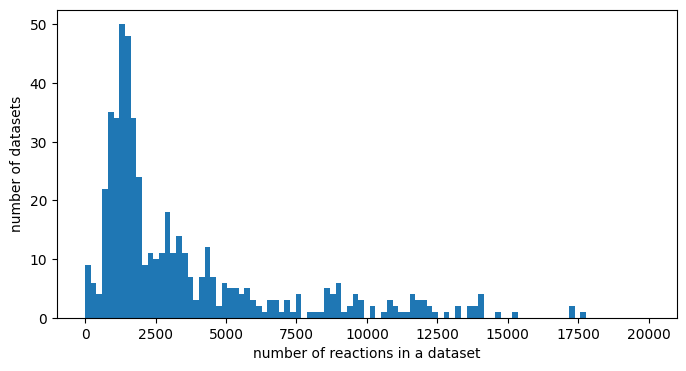

In [ ]:
fig, ax = plt.subplots(figsize =(8, 4))
ax.hist(final_df.dataset_id.value_counts().values, bins = np.linspace(0, 20000, 100))
plt.xlabel('number of reactions in a dataset')
plt.ylabel('number of datasets')

In [ ]:
# swap columns
final_df = final_df[['dataset_id', 'reaction_id', 'reaction_type', 'reaction_smiles', 'inputs_REACTANT', 'inputs_REAGENT', 'inputs_SOLVENT',
         'inputs_CATALYST', 'inputs_INTERNAL', 'inputs_UNSPECIFIED', 'outcomes_PRODUCT', 'outcomes_REACTANT', 'outcomes_CATALYST',
         'outcomes_INTERNAL', 'outcomes_UNSPECIFIED', 'temperature_value', 'temperature_units', 'temperature_control_type',
         'pressure_value', 'pressure_units', 'pressure_control_type', 'atmosphere', 'specific_conditions', 'yields']]
final_df.head()

,dataset_id,reaction_id,reaction_type,reaction_smiles,inputs_REACTANT,inputs_REAGENT,inputs_SOLVENT,inputs_CATALYST,inputs_INTERNAL,inputs_UNSPECIFIED,...,outcomes_UNSPECIFIED,temperature_value,temperature_units,temperature_control_type,pressure_value,pressure_units,pressure_control_type,atmosphere,specific_conditions,yields
0,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-56b1f4bfeebc4b8ab990b9804e798aa7,1.3.1 [N-arylation with Ar-X] Bromo Buchwald-H...,None,"[CC(C)N1CCNCC1, CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=...",[C(=O)([O-])[O-].[Cs+].[Cs+]],[],[C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=...,NaN,NaN,...,NaN,110.0,1,0,1.0,2,0,0,None,[65.38999938964844]
1,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-1169cbe9fa064a879ac34b2e524a4e69,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,None,"[C1=CC=C(C=C1)I, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC]",[C(=O)([O-])[O-].[Cs+].[Cs+]],[COC1=CC=CC=C1],[CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)O...,NaN,NaN,...,NaN,100.0,1,0,1.0,2,0,0,None,[57.470001220703125]
2,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-13992005c22d4673aa802b5e140076e8,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,None,"[C1=CC=C(C=C1)I, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC]",[C(=O)([O-])[O-].[Cs+].[Cs+]],[COC1=CC=CC=C1],[CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)O...,NaN,NaN,...,NaN,100.0,1,0,1.0,2,0,0,None,[65.43000030517578]
3,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-a36b48917c9942d1a34637511773ee1f,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,None,"[C1=CC=C(C=C1)I, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC]",[C(=O)([O-])[O-].[Cs+].[Cs+]],[COC1=CC=CC=C1],[CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)O...,NaN,NaN,...,NaN,100.0,1,0,1.0,2,0,0,None,[75.06999969482422]
4,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-5fc624fd97b7430eafbe8dcc049d170b,0.0 [Unassigned] Unrecognized,None,"[CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C, C1=CC(=CC=...",[C(=O)([O-])[O-].[Cs+].[Cs+]],[CC(=O)N(C)C],[CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)O...,NaN,NaN,...,NaN,150.0,1,0,1.0,2,0,0,None,[46.31999969482422]


In [ ]:
final_df.specific_conditions.unique()

array([None, 'photo', 'flow', 'electro'], dtype=object)

In [ ]:
def remove_list(x):
  '''Converts list of smiles into a comma-separated string'''
  if type(x)==list:
    new_x = ', '.join(['unspecified' if type(i)!=str else str(i) for i in x])
  else:
    new_x = x
  return new_x

In [ ]:
# remove lists from columns with compounds
col_names = [col for col in final_df.columns if 'inputs' in col or 'outcomes' in col]
for col in col_names:
  final_df[col] = final_df[col].apply(remove_list)

In [ ]:
# remove lists from yields column
new_y_list = []
for i in final_df.yields.tolist():
  if i!=[None]:
    i = [str(x) for x in i]
    new_y_list.append(', '.join(i))
  else:
    new_y_list.append(None)
final_df['yields'] = new_y_list

In [ ]:
final_df.head()

,dataset_id,reaction_id,reaction_type,reaction_smiles,inputs_REACTANT,inputs_REAGENT,inputs_SOLVENT,inputs_CATALYST,inputs_INTERNAL,inputs_UNSPECIFIED,...,outcomes_UNSPECIFIED,temperature_value,temperature_units,temperature_control_type,pressure_value,pressure_units,pressure_control_type,atmosphere,specific_conditions,yields
0,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-56b1f4bfeebc4b8ab990b9804e798aa7,1.3.1 [N-arylation with Ar-X] Bromo Buchwald-H...,None,"CC(C)N1CCNCC1, CCOC1=C(C=C2C(=C1)N=CC(=C2NC3=C...",C(=O)([O-])[O-].[Cs+].[Cs+],,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,NaN,NaN,...,NaN,110.0,1,0,1.0,2,0,0,None,65.38999938964844
1,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-1169cbe9fa064a879ac34b2e524a4e69,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,None,"C1=CC=C(C=C1)I, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC",C(=O)([O-])[O-].[Cs+].[Cs+],COC1=CC=CC=C1,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,NaN,NaN,...,NaN,100.0,1,0,1.0,2,0,0,None,57.470001220703125
2,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-13992005c22d4673aa802b5e140076e8,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,None,"C1=CC=C(C=C1)I, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC",C(=O)([O-])[O-].[Cs+].[Cs+],COC1=CC=CC=C1,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,NaN,NaN,...,NaN,100.0,1,0,1.0,2,0,0,None,65.43000030517578
3,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-a36b48917c9942d1a34637511773ee1f,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,None,"C1=CC=C(C=C1)I, CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC",C(=O)([O-])[O-].[Cs+].[Cs+],COC1=CC=CC=C1,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,NaN,NaN,...,NaN,100.0,1,0,1.0,2,0,0,None,75.06999969482422
4,ord_dataset-00005539a1e04c809a9a78647bea649c,ord-5fc624fd97b7430eafbe8dcc049d170b,0.0 [Unassigned] Unrecognized,None,"CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C, C1=CC(=CC=C...",C(=O)([O-])[O-].[Cs+].[Cs+],CC(=O)N(C)C,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,NaN,NaN,...,NaN,150.0,1,0,1.0,2,0,0,None,46.31999969482422


In [ ]:
final_df.to_csv('ord.tsv', sep='\t')
!cp ord.tsv 'drive/My Drive/'